# Visualization Tool for Planet Imagery to QAQC & Analyze NDVI SITS
## Binary Mask -> Binary Summary Stacked Visualizer Isolated

This notebooks focuses on providing the tools necessary to QAQC Planet imagery and to visualization the changes in NDVI over a set or subset of images for a given Area of Interest (AOI). The intention is to be able to determine if a given AOI is increasing or decreasing in vegetation (i.e. greenness) and the general hotspots this may or may not be occurring. This notebook is intended to be used with other preprocessing tools and assumes that the user has a single directory containing analysis-ready NDVI rasters (i.e. single-band -1 to 1 *.tiffs).

### This notebook is only for deriving stacked binary summary masks from binary thresholding masks of NDVI

#### Import Libary Setup

The libraries below must be installed in the Anaconda environment that the user is running this notebook from.

In [1]:
# Imported Python standard libraries
import os
import sys
import datetime
# Imported Python data manipulation libraries
import numpy as np
import rasterio
# Imported Python visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, Label
from IPython.display import display, clear_output

#### User Provided Inputs Setup

Please specify the input folder directory containing all the Planet imagery to be analyzed as NDVI rasters. The absolute folder pathname is recommended along with the use of r" " to reverse the "\\" to "/" automatically.

In [2]:
# input folder directory
planet_input_dir = r"C:\Users\zleady\Desktop\ST_1867\LC\lcr_active_20200621\poh_final_NDVI_Binary_OTSU"

In [3]:
def CreateImgPathList(img_folder):
    """ Creates a Python List of Image Pathnames
    """
    img_path_lst = [os.path.join(img_folder, f) 
                    for f in os.listdir(img_folder)
                    if f.endswith(".tif")]
    return img_path_lst

Invoke the CreateImgPathList function on the planet_input_dir.  
Displays to the user the first and last image/raster pathname and the total number of rasters in the list.

In [4]:
planet_img_path_lst = CreateImgPathList(planet_input_dir)
# Display output checks
print("First Pathname: ", planet_img_path_lst[0])
print("Last Pathname: ", planet_img_path_lst[-1])
print("Total Number of Pathnames: ", len(planet_img_path_lst))

First Pathname:  C:\Users\zleady\Desktop\ST_1867\LC\lcr_active_20200621\poh_final_NDVI_Binary_OTSU\20160808_binary_otsu.tif
Last Pathname:  C:\Users\zleady\Desktop\ST_1867\LC\lcr_active_20200621\poh_final_NDVI_Binary_OTSU\20190512_binary_otsu.tif
Total Number of Pathnames:  297


### Creation of Stacked Binary Mask Period NDVI Images from Binary NDVI Masks

#### Read in Binary NDVI Image Data

In [6]:
# initialize image dictionary
binary_img_dict = {}
# initialize list for images with the wrong shape
incorrect_shape_lst = []

In [7]:
for p in planet_img_path_lst:    
    with rasterio.open(p) as ds:
        temp_arr = ds.read(1)
        temp_dict = {"path": p,
                     "binary_array": temp_arr
                    }
        date_id = os.path.basename(p).split("_")[0]
        if p == planet_img_path_lst[0]:
            x0_shape = temp_arr.shape[0]
            y0_shape = temp_arr.shape[1]
            print("First x0_shape: {}, y0_shape: {}".format(x0_shape, y0_shape))
        if temp_arr.shape[0] == x0_shape and temp_arr.shape[1] == y0_shape:
            binary_img_dict[date_id] = temp_dict
        else:
            incorrect_shape_lst.append([date_id, temp_arr.shape])
    ds.close()

First x0_shape: 1669, y0_shape: 1354


In [8]:
img_key_lst = list(binary_img_dict.keys())
print("Binary images found to have an inconsistent shape [date, (array shape)]: ")
print(incorrect_shape_lst)
print("Started with {} Pathnames".format(len(planet_img_path_lst)))
print("Added {} to Binary Image Dictionary".format(len(img_key_lst)))

Binary images found to have an inconsistent shape [date, (array shape)]: 
[]
Started with 297 Pathnames
Added 297 to Binary Image Dictionary


##### User Set Period Summary Input Dates

The user can define as many comparison periods as desired in the format provided below.

In [9]:
period_lst = [["2018-01-01", "2018-01-31"],
              ["2018-02-01", "2018-02-28"],
              ["2018-03-01", "2018-03-31"],
              ["2018-04-01", "2018-04-30"]]

period_datetime_lst = []
for period in period_lst:
    temp = []
    for p in period:
        _ = datetime.datetime.strptime(p, '%Y-%m-%d').date()
        temp.append(_)
    period_datetime_lst.append(temp)
display(period_datetime_lst)

[[datetime.date(2018, 1, 1), datetime.date(2018, 1, 31)],
 [datetime.date(2018, 2, 1), datetime.date(2018, 2, 28)],
 [datetime.date(2018, 3, 1), datetime.date(2018, 3, 31)],
 [datetime.date(2018, 4, 1), datetime.date(2018, 4, 30)]]

#### User Set QAQC Image List

The user can define which binary images to use from a QAQC process or use all the available binary images.

In [10]:
# manually fill-in with date keys, format i.e. "20180101"
#good_qaqc_img_lst = []

# read-in file with date keys
# good_qaqc_img_lst = []

# use all available binary images
good_qaqc_img_lst = list(binary_img_dict.keys())

#### User Set Binary Algorithm Choice

In [12]:
binary_algo = 'otsu'

In [11]:
period_dict = {k: [] for k in range(len(period_datetime_lst))}
print("Intialized period_dict: ", period_dict)
print("\n")
for date_str in good_qaqc_img_lst:
    date_con = datetime.datetime.strptime(date_str, '%Y%m%d').date()
    for indx, period in enumerate(period_datetime_lst):
        if period[0] <= date_con <= period[1]:
            period_dict.get(indx).append(date_str)
print("Finalized period_dict: ", period_dict)

Intialized period_dict:  {0: [], 1: [], 2: [], 3: []}


Finalized period_dict:  {0: ['20180101', '20180110', '20180112', '20180119', '20180120', '20180122', '20180124', '20180125', '20180126', '20180127'], 1: ['20180201', '20180205', '20180206', '20180208', '20180210', '20180212', '20180216', '20180217', '20180222'], 2: ['20180301', '20180303', '20180308', '20180309', '20180314', '20180315', '20180317'], 3: ['20180406', '20180407', '20180408', '20180410', '20180412', '20180413', '20180414', '20180419', '20180421', '20180422', '20180423']}


In [13]:
def show_ndvi_period_binary_comparison(imageid_1, imageid_2, binary_algo,
                                       title1='NDVI Image Binary Stack 1',
                                       title2='NDVI Image Binary Stack 2',
                                       title3='NDVI Difference of Stack 1 - Stack 2'):
    if isinstance(imageid_1, list) and isinstance(imageid_2, list):
        display_img = []
        for i in [imageid_1, imageid_2]:
            temp_lst = []
            for _id in i:
                temp_arr = binary_img_dict.get(_id).get("binary_array")
                temp_lst.append(temp_arr)
            stacked = np.dstack(temp_lst)
            sum_array = np.sum(stacked, axis=2)
            display_img.append(sum_array)
        # these are arrays "-" overloaded for element-wise subtraction
        difference = display_img[0] - display_img[1]
        # plot display
        plt.figure(figsize=(30, 12))
        plt.subplot(1, 3, 1)
        plt.imshow(display_img[0], cmap=plt.cm.viridis)
        plt.title(title1)
        plt.colorbar()
        plt.clim(-1, 1)
        plt.subplot(1, 3, 2)
        plt.imshow(display_img[1], cmap=plt.cm.viridis)
        plt.title(title2)
        plt.colorbar()
        plt.clim(-1, 1)
        plt.subplot(1, 3, 3)
        plt.imshow(difference, cmap=plt.cm.viridis)
        plt.title(title3)
        plt.colorbar()
        plt.clim(-1, 1)
        plt.show()
    else:
        print("Input types do not match")
        return 1

In [14]:
p_lst_options = []
for date_pair in period_datetime_lst:
    d1 = date_pair[0].strftime('%Y/%m/%d')
    d2 = date_pair[1].strftime('%Y/%m/%d')
    p_lst_options.append("{} to {}".format(d1, d2))

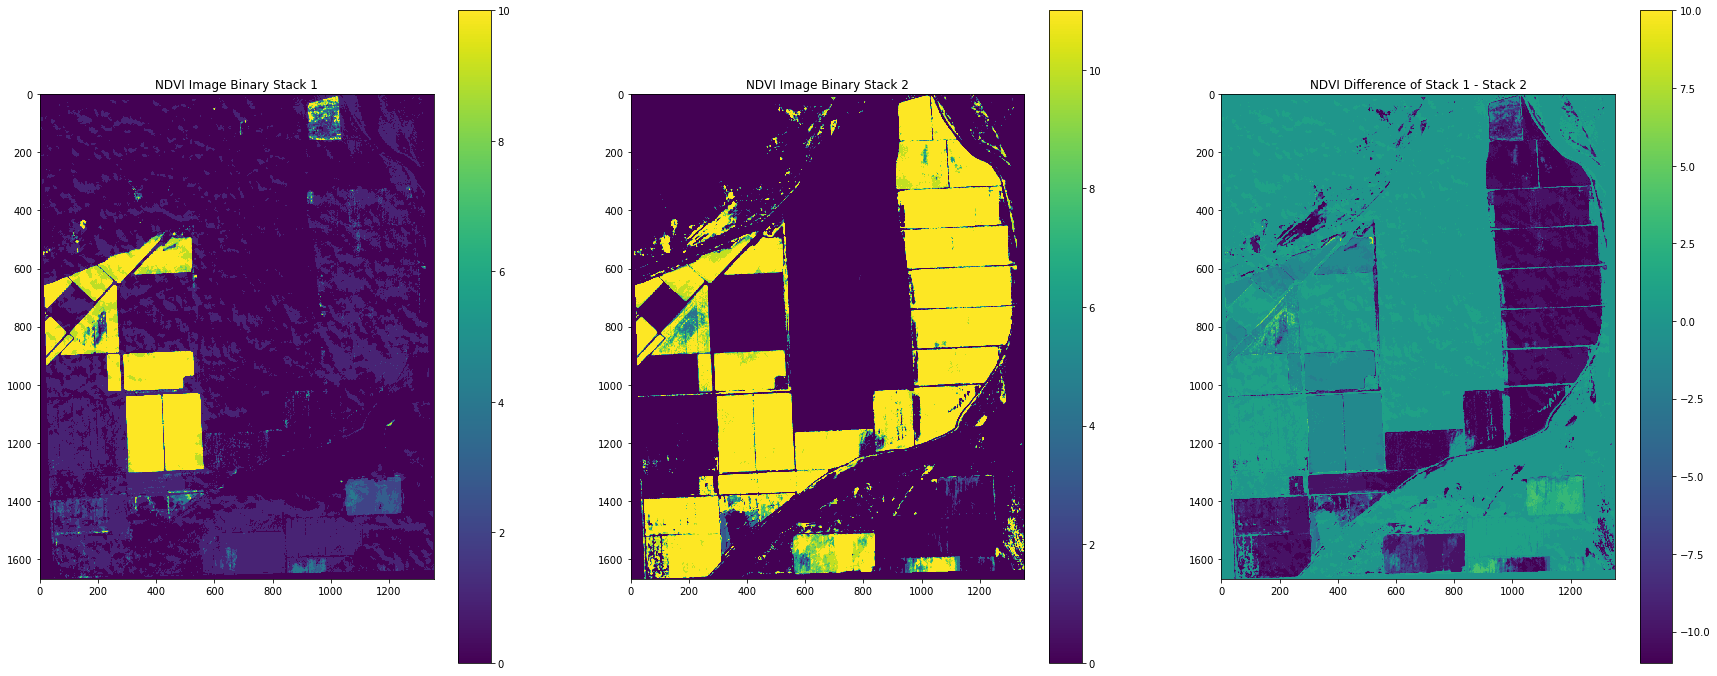

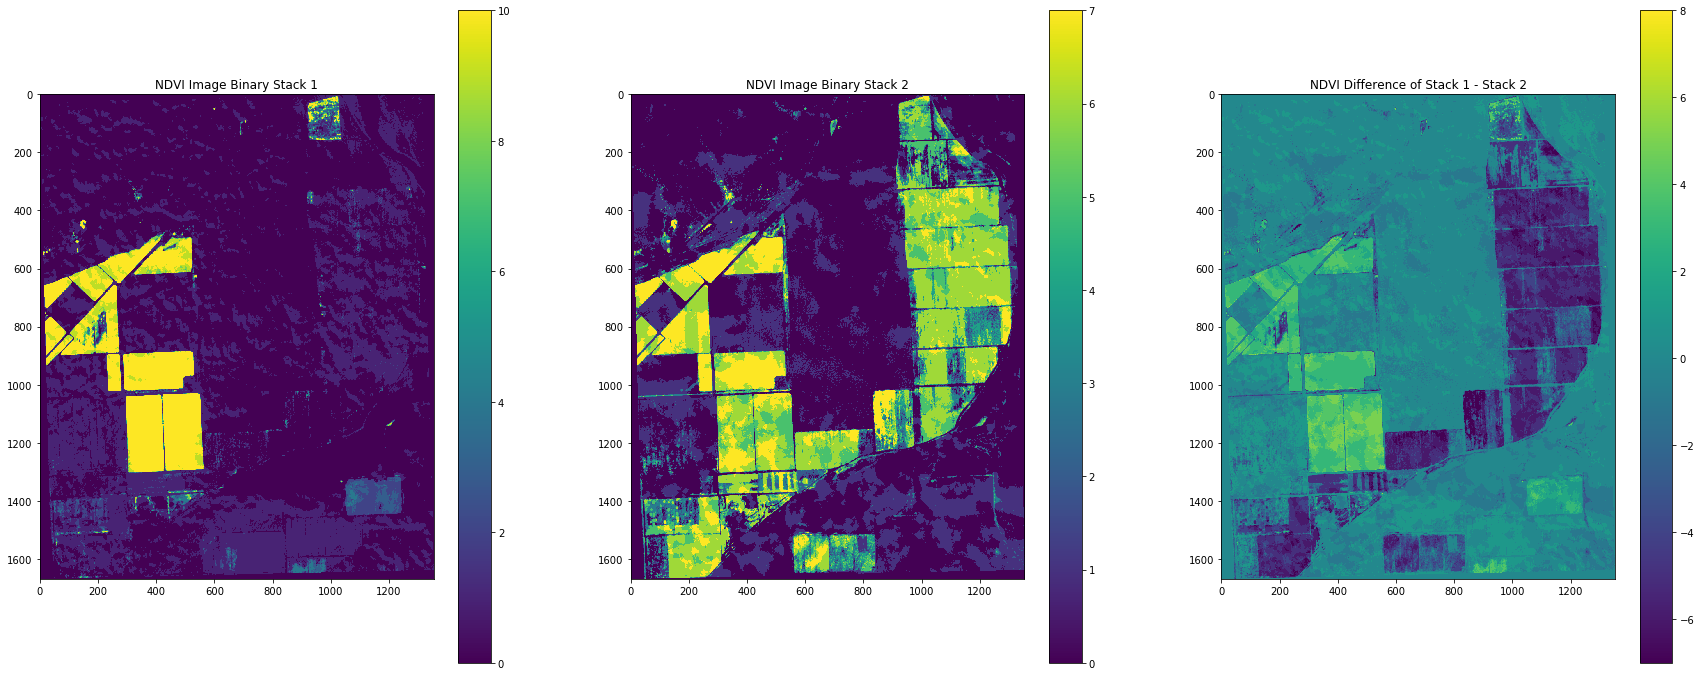

In [15]:
binary_difference_options = p_lst_options
first_binary_dropdown = widgets.Dropdown(options=binary_difference_options,
                                         value=binary_difference_options[0],
                                         description=' ',)
second_binary_dropdown = widgets.Dropdown(options=binary_difference_options,
                                          value=binary_difference_options[-1],
                                          description=' ',)
binary_clear_button = widgets.Button(description='Clear all Images',
                                     disabled=False,
                                     button_style='', 
                                     tooltip='Click me to Clear all Images from display',
                                     icon='remove')


def binary_clear_button_eventhandler(obj):
    clear_output()
    display(HBox([Label("Please choose dates to compare: "), first_binary_dropdown,
                  second_binary_dropdown, binary_clear_button]))
    
def binary_first_onchange(change):
    if change['type'] == 'change' and change['name'] == 'value':
        indx1 = p_lst_options.index(change['new'])
        indx2 = p_lst_options.index(second_binary_dropdown.value)
        show_ndvi_period_binary_comparison(period_dict.get(indx1), period_dict.get(indx2), binary_algo)
    
def binary_second_onchange(change):
    if change['type'] == 'change' and change['name'] == 'value':
        indx1 = p_lst_options.index(first_binary_dropdown.value)
        indx2 = p_lst_options.index(change['new'])
        show_ndvi_period_binary_comparison(period_dict.get(indx1), period_dict.get(indx2), binary_algo)

first_binary_dropdown.observe(binary_first_onchange)
second_binary_dropdown.observe(binary_second_onchange)
binary_clear_button.on_click(binary_clear_button_eventhandler)

display(HBox([Label("Please choose dates to compare: "), first_binary_dropdown, second_binary_dropdown, binary_clear_button]))
indx_binary_2 = len(p_lst_options) - 1
show_ndvi_period_binary_comparison(period_dict.get(0), period_dict.get(indx_binary_2), binary_algo)

### Export Stacked Binary Period NDVI Imagery

The following cells export the stacked binary period NDVI images as "*.tif" rasters using their original NDVI metadata.
  
The user can view the rasters in their preferred GIS program (i.e. ArcGIS, QGIS, etc.)  
OR  
the rasters can be read by a Python library such as rasterio back into numpy arrays.

In [18]:
output_dir = os.path.join(os.path.dirname(planet_input_dir), "poh_final_NDVI_Stacked_Binary_{}".format(binary_algo.upper()))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
print("All stacked binary period rasters will be written too: ")
print(output_dir)

All stacked binary period rasters will be written too: 
C:\Users\zleady\Desktop\ST_1867\LC\lcr_active_20200621\poh_final_NDVI_Stacked_Binary_OTSU


In [25]:
stack_img_dict = {}
for period in sorted(list(period_dict.keys())):
    period_ids = period_dict.get(period) 
    temp_lst = []
    for p_ids in period_ids:
        temp_arr = binary_img_dict.get(p_ids).get("binary_array")
        temp_lst.append(temp_arr)
    stacked = np.dstack(temp_lst)
    sum_array = np.sum(stacked, axis=2)
    stack_img_dict[period] = sum_array
print("{} Stacked Binary Period Rasters".format(len(list(stack_img_dict.keys()))))
display(list(stack_img_dict.keys()))

difference_img_dict = {}
for p1 in sorted(list(stack_img_dict.keys())):
    for p2 in sorted(list(stack_img_dict.keys())):
        if not p1 == p2:
            p1_arr = stack_img_dict.get(p1)
            p2_arr = stack_img_dict.get(p2)
            difference_array = p1_arr - p2_arr
            p1_name = p_lst_options[p1].replace("/", "_").replace(" to ", "_") 
            p2_name = p_lst_options[p2].replace("/", "_").replace(" to ", "_")
            difference_img_dict["{}-{}".format(p1_name, p2_name)] = difference_array
print("{} Difference Stacked Binary Period Rasters".format(len(list(difference_img_dict.keys()))))
display(list(difference_img_dict.keys()))

stack_img_dict = {p_lst_options[k].replace("/", "_").replace(" to ", "_"): v for k, v in stack_img_dict.items()}
display(list(stack_img_dict.keys()))


def write_img_dict_to_raster(img_dict, reference_raster_date):
    retrieve_path = binary_img_dict.get("{}".format(reference_raster_date)).get("path")
    assert os.path.exists(retrieve_path)
    print("{} date raster being used as kwargs reference".format(reference_raster_date))
    for key in list(img_dict.keys()):
        temp_arr = img_dict.get(key)
        with rasterio.open(retrieve_path) as orig_dst:
            kwargs = orig_dst.meta
            kwargs.update(dtype=rasterio.float32, count=1)        
            output_path = os.path.join(output_dir,
                                       "stacked_{}_b.tif".format(key))
            with rasterio.open(output_path, 'w', **kwargs) as dst:
                dst.write_band(1, img_dict.get(key).astype(rasterio.float32))
        print("Wrote {} stacked array".format(key))

4 Stacked Binary Period Rasters


[0, 1, 2, 3]

12 Difference Stacked Binary Period Rasters


['2018_01_01_2018_01_31-2018_02_01_2018_02_28',
 '2018_01_01_2018_01_31-2018_03_01_2018_03_31',
 '2018_01_01_2018_01_31-2018_04_01_2018_04_30',
 '2018_02_01_2018_02_28-2018_01_01_2018_01_31',
 '2018_02_01_2018_02_28-2018_03_01_2018_03_31',
 '2018_02_01_2018_02_28-2018_04_01_2018_04_30',
 '2018_03_01_2018_03_31-2018_01_01_2018_01_31',
 '2018_03_01_2018_03_31-2018_02_01_2018_02_28',
 '2018_03_01_2018_03_31-2018_04_01_2018_04_30',
 '2018_04_01_2018_04_30-2018_01_01_2018_01_31',
 '2018_04_01_2018_04_30-2018_02_01_2018_02_28',
 '2018_04_01_2018_04_30-2018_03_01_2018_03_31']

['2018_01_01_2018_01_31',
 '2018_02_01_2018_02_28',
 '2018_03_01_2018_03_31',
 '2018_04_01_2018_04_30']

Write out each Stacked Period Binary Mask to a Raster

In [26]:
write_img_dict_to_raster(stack_img_dict, good_qaqc_img_lst[0])

20160808 date raster being used as kwargs reference
Wrote 2018_01_01_2018_01_31 stacked array
Wrote 2018_02_01_2018_02_28 stacked array
Wrote 2018_03_01_2018_03_31 stacked array
Wrote 2018_04_01_2018_04_30 stacked array


Write out each Stacked Period Difference Binary Mask to a Raster

In [27]:
write_img_dict_to_raster(difference_img_dict, good_qaqc_img_lst[-1])

20190512 date raster being used as kwargs reference
Wrote 2018_01_01_2018_01_31-2018_02_01_2018_02_28 stacked array
Wrote 2018_01_01_2018_01_31-2018_03_01_2018_03_31 stacked array
Wrote 2018_01_01_2018_01_31-2018_04_01_2018_04_30 stacked array
Wrote 2018_02_01_2018_02_28-2018_01_01_2018_01_31 stacked array
Wrote 2018_02_01_2018_02_28-2018_03_01_2018_03_31 stacked array
Wrote 2018_02_01_2018_02_28-2018_04_01_2018_04_30 stacked array
Wrote 2018_03_01_2018_03_31-2018_01_01_2018_01_31 stacked array
Wrote 2018_03_01_2018_03_31-2018_02_01_2018_02_28 stacked array
Wrote 2018_03_01_2018_03_31-2018_04_01_2018_04_30 stacked array
Wrote 2018_04_01_2018_04_30-2018_01_01_2018_01_31 stacked array
Wrote 2018_04_01_2018_04_30-2018_02_01_2018_02_28 stacked array
Wrote 2018_04_01_2018_04_30-2018_03_01_2018_03_31 stacked array


En Fin.